# Coral Bleaching
# Modeling

1. Imports
2. Initial Evaluation of Models and Sampling Methods
3. Feature Importance
4. Hyperparameter Tuning
5. Compare Tuned Models
6. Select & Save Final Model

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC  # use linearSVC if taking too long (better for larger data sets)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics & evalulation
from sklearn import __version__ as sklearn_version 
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score,
                              recall_score, f1_score,
                              confusion_matrix, ConfusionMatrixDisplay)

seed = 5

In [2]:
# import undersampled data
datapath1 = '../data/processed/undersample_data/'
data_files = ['X_train_data.csv', 'X_train_scaled_data.csv', 'y_train_data.csv', 
              'X_test_data.csv', 'X_test_scaled_data.csv', 'y_test_data.csv']


X_tr_under, X_tr_under_scl, y_tr_under, X_ts_under, X_ts_under_scl, y_ts_under = \
                            (pd.read_csv(datapath1 + filename, index_col='Unnamed: 0') for filename in data_files)
y_tr_under = y_tr_under.values.ravel()
y_ts_under = y_ts_under.values.ravel()

In [3]:
# import oversampled data
datapath2 = '../data/processed/oversample_data/'
data_files = ['X_train_data.csv', 'X_train_scaled_data.csv', 'y_train_data.csv', 
              'X_test_data.csv', 'X_test_scaled_data.csv', 'y_test_data.csv']


X_tr_over, X_tr_over_scl, y_tr_over, X_ts_over, X_ts_over_scl, y_ts_over = \
                            (pd.read_csv(datapath2 + filename, index_col='Unnamed: 0') for filename in data_files)
y_tr_over = y_tr_over.values.ravel()
y_ts_over = y_ts_over.values.ravel()

## 2. Initial Evaluation of Models and Sampling Methods

Since this is a classification problem with supervised learning, I will start by evaluating the following models:

- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [K Nearest Neighbors(KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/)

Initially I will be comparing how these models perform out of the box. While the results include accuracy, precision, recall, and F1 scores, I will ultimately be focused on the F1 scores since it minimizes both false negatives and false positives. After seeing how all of the models perform on both the undersampled and over sampled data, I can determine which sampling method produced the best results. Additionally, I will assess which models have the best performance and select 2-3 models to continue with further feature selection and hyperparameter tuning. 

As a note, I am using the scaled data at this initial step because logistic regression and KNN need scaled data in order to equally weight all features. In later steps, I may change to unscaled data as applicable if fine tuning tree based models in order to simplify the interpretability of the results. 

In [4]:
# function to evaluate metrics for each classifier
def score_predictions(y_test, y_pred):
    '''
    takes test and predicted y,
    returns accuracy, precision, recall, and f1 scores. 
    '''
    
    scores = {}
    scores['accuracy'] = accuracy_score(y_test, y_pred)
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['f1'] = f1_score(y_test, y_pred)
    
    return scores
    

# function modeling each classifier 
def compare_classifiers(classifiers, X, y, metrics):
    '''
    takes list of classifiers, X, y, and list of scoring metrics,
    returns dataframe of the classifiers and their respective scores. 
    '''
    scores_agg = pd.DataFrame()
    
    for clf in classifiers:
        cv_clf = cross_val_predict(clf, X, y, cv=5)
        scores = score_predictions(y, cv_clf)
        clf_name = clf.__class__.__name__
        row = [clf_name] + [scores[metric] for metric in metrics]
        scores_agg = pd.concat([scores_agg, pd.Series(row)], axis=1)

    cols = ['Classifier'] + metrics
    scores_agg = pd.DataFrame(scores_agg.T)
    scores_agg.columns = cols
    scores_agg.set_index('Classifier', inplace=True)
    
    return scores_agg


In [5]:
# Establish classifiers and metrics of interest
# LogisticRegression needed increased max_iter
classifier_list = [LogisticRegression(max_iter=500), SVC(), KNeighborsClassifier(), 
                   DecisionTreeClassifier(), RandomForestClassifier(), 
                   GradientBoostingClassifier(), XGBClassifier()]

metrics = ['accuracy', 'precision', 'recall', 'f1']

### 2a. Undersampled Data

In [6]:
# initial comparison of undersampled data
initial_under = compare_classifiers(classifier_list, X_tr_under_scl, y_tr_under, metrics)
initial_under

,accuracy,precision,recall,f1
Classifier,,,,
LogisticRegression,0.721139,0.709282,0.746271,0.727306
SVC,0.797289,0.820423,0.759433,0.788751
KNeighborsClassifier,0.816154,0.820148,0.808324,0.814193
DecisionTreeClassifier,0.846139,0.841213,0.852075,0.846609
RandomForestClassifier,0.89905,0.902544,0.893945,0.898224
GradientBoostingClassifier,0.797226,0.806214,0.780745,0.793275
XGBClassifier,0.872314,0.879882,0.861351,0.870518


Text(0.5, 1.0, 'Initial Model Comparison - Undersampled Data')

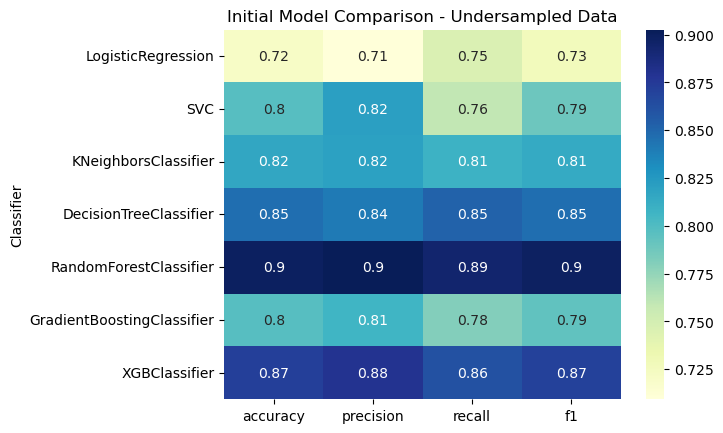

In [7]:
# Visualize scores via heatmap
sns.heatmap(initial_under.astype('float'), cmap='YlGnBu', annot=True)
plt.title('Initial Model Comparison - Undersampled Data')

### 2b. Oversampled Data

In [8]:
# initial comparison of oversampled data
initial_over = compare_classifiers(classifier_list, X_tr_over_scl, y_tr_over, metrics)
initial_over

,accuracy,precision,recall,f1
Classifier,,,,
LogisticRegression,0.74387,0.725837,0.781702,0.752734
SVC,0.829669,0.845188,0.80613,0.825197
KNeighborsClassifier,0.878815,0.867361,0.893678,0.880323
DecisionTreeClassifier,0.919193,0.928772,0.907577,0.918053
RandomForestClassifier,0.948241,0.953305,0.942379,0.94781
GradientBoostingClassifier,0.841335,0.857003,0.818422,0.837269
XGBClassifier,0.924444,0.939407,0.907007,0.922923


Text(0.5, 1.0, 'Initial Model Comparison - Oversampled Data')

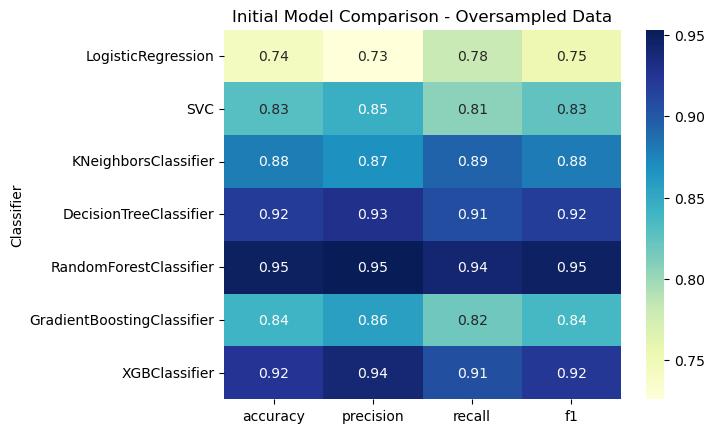

In [9]:
# Visualize scores via heatmap
sns.heatmap(initial_over.astype('float'), cmap='YlGnBu', annot=True)
plt.title('Initial Model Comparison - Oversampled Data')

The following three classifers performed the best regardless of sampling method. These classifiers are shortlisted and will continue to be used in futher hyperparameter tuning:
- Decision Tree
- Random Forest
- XGBoost

Out of the box, Random Forest performs the best across all metrics, with XGBoost and Decision Tree only a couple basis points behind. Decision Tree is much faster and more efficient than the other two ensemble models, and therefore could be attractive if it's performance can be fine tuned. 

These results show that the oversampled data produces higher scores across all models. However, this increase in performance is relatively small, and the undersampled data will be a better representation of the original data. Since the undersampled dataset is still reatively large, with about 16,000 and 4,000 observations in the train and test sets, respectively. 

*I will also be using the unscaled data moving forward because these three models are tree based, and therefore do not required scaled data.*

## 3. Feature Importance


At this stage, I am interested in what features are most important. As part of the hyperparameter tuning in the next step, I will want to compare how the models perform with a reduced number of features. Reducing the number of features can help interpretability as well as mitigate overfitting of the models.

In [10]:
# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=seed)
dt_clf.fit(X_tr_under, y_tr_under)

# Random Forest
rf_clf = RandomForestClassifier(random_state=seed)
rf_clf.fit(X_tr_under, y_tr_under)

# XGBoost
xgb_clf = XGBClassifier(random_state=seed)
xgb_clf.fit(X_tr_under, y_tr_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=5, ...)

In [11]:
def graph_importance(clf):
    importance = pd.DataFrame(clf.feature_importances_, columns=['importance'])
    importance['feature'] = X_tr_under.columns
    importance.sort_values(by='importance', ascending=False)

    sns.barplot(data=importance.sort_values(by='importance', ascending=False),
                y='feature', x='importance')
    plt.title(clf.__class__.__name__ + ' Feature Importance')
    plt.show()

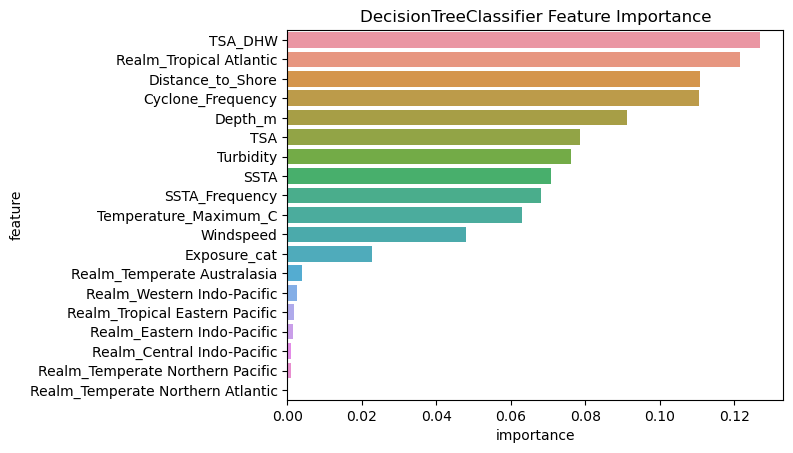

In [12]:
graph_importance(dt_clf)

In [13]:
# Select features with importance greater than ~0.08
dt_features = ['TSA_DHW', 'Realm_Tropical Atlantic', 'Distance_to_Shore', 'Cyclone_Frequency', 
               'Depth_m'] #'TSA', 'Turbidity'

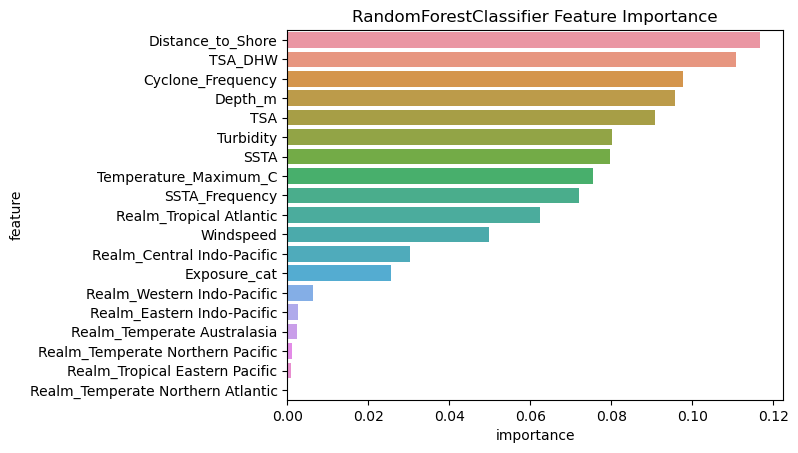

In [14]:
graph_importance(rf_clf)

In [15]:
# Select features with importance greater than ~0.08
rf_features = ['Distance_to_Shore', 'TSA_DHW', 'Cyclone_Frequency', 
               'Depth_m', 'TSA'] #'Turbidity', 'SSTA'

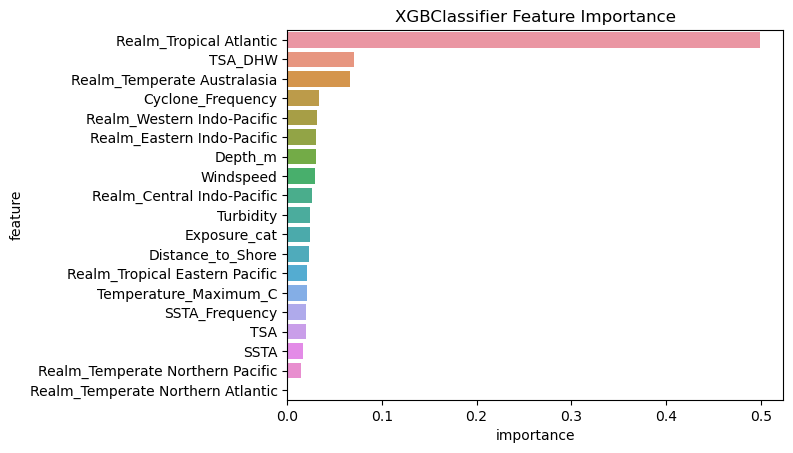

In [16]:
graph_importance(xgb_clf)

In [17]:
# Select features where importance appears to drop off (after Cyclone_Frequency)
xgb_features = ['Realm_Tropical Atlantic', 'TSA_DHW', 'Realm_Temperate Australasia', 
                'Cyclone_Frequency', 'Realm_Western Indo-Pacific', 
                'Realm_Eastern Indo-Pacific', 'Depth_m', 'Windspeed']

## 4. Hyperparameter Tuning

In [18]:
def model_evaluation(classifier, params, X_train, y_train, X_test, y_test):
    '''
    Takes classifier name, dict of parameters, X_train, y_train, X_test, y_test, 
    prints best parameters and scores, 
    returns fit model with best parameters and scores.
    '''
    start_time = datetime.now()
    
    # grid search cross validation for best params
    clf = classifier(random_state=seed)
    cv = GridSearchCV(clf, params, cv=5)
    cv.fit(X_train, y_train)
    
    # fit and predict model with best params
    best_clf = classifier(**cv.best_params_)
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    
    # calculate scores
    scores = score_predictions(y_test, y_pred)
    
    print(f'Total Run Time: {datetime.now() - start_time}')
    print('')
    print(f'Best Parameters: {cv.best_params_}')
    print('')
    print('Test data scores ')
    for x in scores:
        print(x, ':', scores[x])
        
    return best_clf, scores

### 4a. Decision Tree
#### 4a i. All Features

In [19]:
dt_params = {'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_dt, best_dt_scores = model_evaluation(DecisionTreeClassifier, dt_params, 
                           X_tr_under, y_tr_under, X_ts_under, y_ts_under)

Total Run Time: 0:00:03.260798

Best Parameters: {'criterion': 'gini', 'max_depth': 25}

Test data scores 
accuracy : 0.8598200899550225
precision : 0.8654708520179372
recall : 0.856508875739645
f1 : 0.8609665427509293


#### 4a ii. Reduced Features

In [20]:
# reduced features selected in previous section
X_tr_dt = X_tr_under[dt_features]
X_ts_dt = X_ts_under[dt_features]

dt_params = {'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_dt_reduced, best_dt_reduced_scores = model_evaluation(DecisionTreeClassifier, dt_params, 
                                   X_tr_dt, y_tr_under, X_ts_dt, y_ts_under)

Total Run Time: 0:00:01.405253

Best Parameters: {'criterion': 'gini', 'max_depth': 30}

Test data scores 
accuracy : 0.844327836081959
precision : 0.8528377699648418
recall : 0.8372781065088757
f1 : 0.8449863150037322


### 4b. Random Forest
#### 4b i. All Features

In [21]:
rf_params = {'n_estimators':[50, 100, 150],
             'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_rf, best_rf_scores = model_evaluation(RandomForestClassifier, rf_params, 
                           X_tr_under, y_tr_under, X_ts_under, y_ts_under)

Total Run Time: 0:02:38.006765

Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 150}

Test data scores 
accuracy : 0.9110444777611194
precision : 0.9192577733199598
recall : 0.9038461538461539
f1 : 0.9114868224763798


#### 4b ii. Reduced Features

In [22]:
# reduced features selected in previous section
X_tr_rf = X_tr_under[rf_features]
X_ts_rf = X_ts_under[rf_features]

rf_params = {'n_estimators':[50, 100, 150],
             'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_rf_reduced, best_rf_reduced_scores = model_evaluation(RandomForestClassifier, rf_params, 
                                   X_tr_rf, y_tr_under, X_ts_rf, y_ts_under)

Total Run Time: 0:02:32.085562

Best Parameters: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 150}

Test data scores 
accuracy : 0.8778110944527736
precision : 0.8904109589041096
recall : 0.8653846153846154
f1 : 0.8777194298574644


### 4c. XGBoost
#### 4c i. All Features

In [23]:
xgb_params = {'max_depth': [5, 10, 15, 25, 30], 
              'n_estimators': [50, 100, 150],
              'reg_alpha': [0.05, 0.1, 1.0], 
              'reg_lambda': [0.05, 1.0, 2.0]}

best_xgb, best_xgb_scores = model_evaluation(XGBClassifier, xgb_params, 
                            X_tr_under, y_tr_under, X_ts_under, y_ts_under)

Total Run Time: 0:03:15.558880

Best Parameters: {'max_depth': 15, 'n_estimators': 150, 'reg_alpha': 1.0, 'reg_lambda': 2.0}

Test data scores 
accuracy : 0.914792603698151
precision : 0.918195339613287
recall : 0.9132149901380671
f1 : 0.9156983930778738


#### 4c ii. Reduced Features

In [24]:
# reduced features selected in previous section
X_tr_xgb = X_tr_under[xgb_features]
X_ts_xgb = X_ts_under[xgb_features]

xgb_params = {'max_depth': [5, 10, 15, 25, 30], 
              'n_estimators': [50, 100, 150],
              'reg_alpha': [0.05, 0.1, 1.0], 
              'reg_lambda': [0.05, 1.0, 2.0]}

best_xgb_reduced, best_xgb_reduced_scores = model_evaluation(XGBClassifier, xgb_params, 
                                    X_tr_xgb, y_tr_under, X_ts_xgb, y_ts_under)

Total Run Time: 0:02:14.001356

Best Parameters: {'max_depth': 10, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 0.05}

Test data scores 
accuracy : 0.8588205897051474
precision : 0.8726439123790117
recall : 0.8446745562130178
f1 : 0.858431470809321


## 5. Compare Tuned Model

Text(0.5, 1.0, 'Tuned Tree-Based Models Scores')

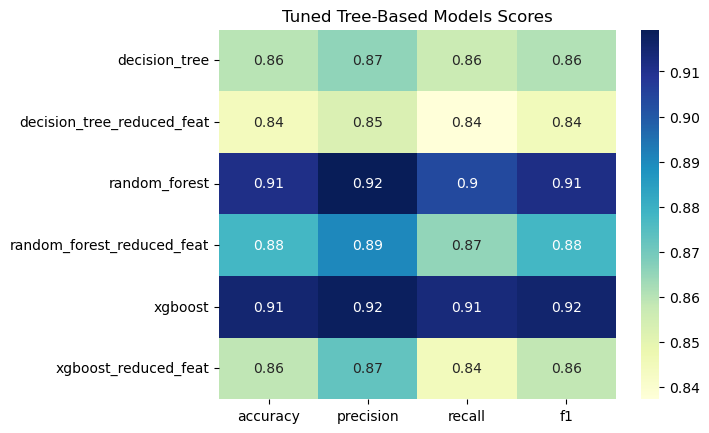

In [25]:
# combine scores into one dataframe with model names 
tuned_scores = [best_dt_scores, best_dt_reduced_scores, best_rf_scores, 
                best_rf_reduced_scores, best_xgb_scores, best_xgb_reduced_scores]
models = ['decision_tree', 'decision_tree_reduced_feat', 'random_forest', 
          'random_forest_reduced_feat', 'xgboost', 'xgboost_reduced_feat']
scores = pd.DataFrame(data=tuned_scores, index = models)

# plot heatmap of scores 
sns.heatmap(scores, cmap='YlGnBu', annot=True)
plt.title('Tuned Tree-Based Models Scores')

### 5a. Checking for Overfitting

In [32]:
# Cross valitation of training data

# full features
dt_cv_scores = cross_val_score(best_dt, X_tr_under, y_tr_under, scoring='f1', cv=5)
rf_cv_scores = cross_val_score(best_rf, X_tr_under, y_tr_under, scoring='f1', cv=5)
xgb_cv_scores = cross_val_score(best_xgb, X_tr_under, y_tr_under, scoring='f1', cv=5)

# reduced features
dt2_cv_scores = cross_val_score(best_dt_reduced, X_tr_dt, y_tr_under, scoring='f1', cv=5)
rf2_cv_scores = cross_val_score(best_rf_reduced, X_tr_rf, y_tr_under, scoring='f1', cv=5)
xgb2_cv_scores = cross_val_score(best_xgb_reduced, X_tr_xgb, y_tr_under, scoring='f1', cv=5)

print('Training Cross Validation Scores')
print(f'Decision Tree (full):    {dt_cv_scores.mean():.4f} mean F1 score with {dt_cv_scores.std():.4f} std')
print(f'Decision Tree (reduced): {dt2_cv_scores.mean():.4f} mean F1 score with {dt2_cv_scores.std():.4f} std')
print(f'Random Forest (full):    {rf_cv_scores.mean():.4f} mean F1 score with {rf_cv_scores.std():.4f} std')
print(f'Random Forest (reduced): {rf2_cv_scores.mean():.4f} mean F1 score with {rf2_cv_scores.std():.4f} std')
print(f'XGBoost (full):          {xgb_cv_scores.mean():.4f} mean F1 score with {xgb_cv_scores.std():.4f} std')
print(f'XGBoost (reduced):       {xgb2_cv_scores.mean():.4f} mean F1 score with {xgb2_cv_scores.std():.4f} std')

Training Cross Validation Scores
Decision Tree (full):    0.8485 mean F1 score with 0.0084 std
Decision Tree (reduced): 0.8257 mean F1 score with 0.0020 std
Random Forest (full):    0.8974 mean F1 score with 0.0046 std
Random Forest (reduced): 0.8709 mean F1 score with 0.0018 std
XGBoost (full):          0.8987 mean F1 score with 0.0042 std
XGBoost (reduced):       0.8477 mean F1 score with 0.0091 std


As is expected, the reduced feature models have lower average F1 scores. However, the standard deviations of Decision Tree and Random Forest models with reduced features are noticably lower than that of the other cross validation scores. This implies that these two models are better at generalizing the data and produce more consistant results. 

The following analysis is another way to look at overfitting by seeing how training and test F1 scores compare to each other. 

In [28]:
# Decision tree
# compare train and test scores
tr1_pred = best_dt.predict(X_tr_under)
tr_dt_scores = score_predictions(y_tr_under, tr1_pred)

tr2_pred = best_dt_reduced.predict(X_tr_dt)
tr_dt_reduced_scores = score_predictions(y_tr_under, tr2_pred)

print('Decision Tree All Features: ')
print(f"Predicted train F1 score: {tr_dt_scores['f1']}")
print(f"Predicted test F1 score: {best_dt_scores['f1']}")
print(f"Difference: {tr_dt_scores['f1'] - best_dt_scores['f1']}")
print('')
print('Decision Tree Reduced Features: ')
print(f"Predicted train F1 score: {tr_dt_reduced_scores['f1']}")
print(f"Predicted test F1 score: {best_dt_reduced_scores['f1']}")
print(f"Difference: {tr_dt_reduced_scores['f1'] - best_dt_reduced_scores['f1']}")

Decision Tree All Features: 
Predicted train F1 score: 0.9942167462911742
Predicted test F1 score: 0.8609665427509293
Difference: 0.13325020354024486

Decision Tree Reduced Features: 
Predicted train F1 score: 0.9826356001768012
Predicted test F1 score: 0.8449863150037322
Difference: 0.13764928517306896


In [29]:
# Random Forest
# compare train and test scores
tr1_pred = best_rf.predict(X_tr_under)
tr_rf_scores = score_predictions(y_tr_under, tr1_pred)

tr2_pred = best_rf_reduced.predict(X_tr_rf)
tr_rf_reduced_scores = score_predictions(y_tr_under, tr2_pred)

print('Random Forest All Features: ')
print(f"Predicted train F1 score: {tr_rf_scores['f1']}")
print(f"Predicted test F1 score: {best_rf_scores['f1']}")
print(f"Difference: {tr_rf_scores['f1'] - best_rf_scores['f1']}")
print('')
print('Random Forest Reduced Features: ')
print(f"Predicted train F1 score: {tr_rf_reduced_scores['f1']}")
print(f"Predicted test F1 score: {best_rf_reduced_scores['f1']}")
print(f"Difference: {tr_rf_reduced_scores['f1'] - best_rf_reduced_scores['f1']}")

Random Forest All Features: 
Predicted train F1 score: 0.9980580091461505
Predicted test F1 score: 0.9114868224763798
Difference: 0.0865711866697707

Random Forest Reduced Features: 
Predicted train F1 score: 0.9980577658041475
Predicted test F1 score: 0.8777194298574644
Difference: 0.12033833594668308


In [30]:
# XGBoost
# compare train and test scores
tr1_pred = best_xgb.predict(X_tr_under)
tr_xgb_scores = score_predictions(y_tr_under, tr1_pred)

tr2_pred = best_xgb_reduced.predict(X_tr_xgb)
tr_xgb_reduced_scores = score_predictions(y_tr_under, tr2_pred)

print('XGB All Features: ')
print(f"Predicted train F1 score: {tr_xgb_scores['f1']}")
print(f"Predicted test F1 score: {best_xgb_scores['f1']}")
print(f"Difference: {tr_xgb_scores['f1'] - best_xgb_scores['f1']}")
print('')
print('XGB Reduced Features: ')
print(f"Predicted train F1 score: {tr_xgb_reduced_scores['f1']}")
print(f"Predicted test F1 score: {best_xgb_reduced_scores['f1']}")
print(f"Difference: {tr_xgb_reduced_scores['f1'] - best_xgb_reduced_scores['f1']}")

XGB All Features: 
Predicted train F1 score: 0.9974322039205863
Predicted test F1 score: 0.9156983930778738
Difference: 0.08173381084271247

XGB Reduced Features: 
Predicted train F1 score: 0.9628973027732051
Predicted test F1 score: 0.858431470809321
Difference: 0.10446583196388404


After comparing the F1 scores from predictions using training data to the test scores, Random Forest with reduced features has a larger decrease in score compared to Random Forest with all features and both XGBoost models. herefore does not appear to predict the new, unseen data well and implies overfitting despire the results seen in the cross validation scores. 

XGBoost with all features has the lowest difference between training and test F1 scores, in addition to it's relatively high average cross validation score and middling standard deviation of F1 scores. For my purposes, this model is adequate for predicting where coral bleaching is present, while also reducing overfitting.

## 6. Select & Save Final Model

In [33]:
final_model = best_xgb

# assign model details
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.X_columns = [col for col in X_tr_under.columns] 
final_model.build_datetime = datetime.now()


# save final model as pickle file
model_path_file = '../models/coral_bleaching_prediction_model.pkl'

with open(model_path_file, 'wb') as file: 
    pickle.dump(final_model, file)